# Class Rebalancing Dataset 만들기


```
├datasets_balanced/
├── base/       ← 처음 제공된 데이터셋을 8:1:1로 분할
│ 	├── train/ 	← base 모델 학습용
│ 	├── val/ 	← base 모델 검증용 (개수 적은 class는 전부 test로 보냄)
│ 	└── test/ 	← base 모델 성능 평가용 (label있음, rare class 일부 포함됨, finetune후 사용x)
│
├── rare/       ← base 전체 데이터 중 50개 미만인 클래스 모음
│	├── original/ 	← 가공 없는 원본 데이터
│	├── aug/ 	← original의 증강 버전
│	├── aug_g/ 	← 생성형 모델로 증강 버전 (aug와 비교용)
│	└── folds/ 	← fine-tuning용 K-Fold 분할
│
└── test_k/ 		← 케글 제출용 test set
```


# 0. 환경 준비

In [ ]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 경로 및 변수 설정 (코랩용 임시)
import torch

BASE_DIR = '/content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/'   # 루트 폴더
DATASET_DIR = f"{BASE_DIR}/datasets_balanced/base"
# ANNOT_PATH = f"{DATASET_DIR}/datasets_balanced/coco_annotations_final.json"

SPLITS = {
    "train": f"{DATASET_DIR}/train",
    "val": f"{DATASET_DIR}/val",
    "test": f"{DATASET_DIR}/test",
}

# 1. 데이터 탐색 및 전처리

## 1.1 Roboflow에서 train/val 8:2로 분할한 데이터셋 클래스 분포 확인

⚠️ Val에 없는 클래스: [46]


/tmp/ipython-input-1211593281.py:69: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


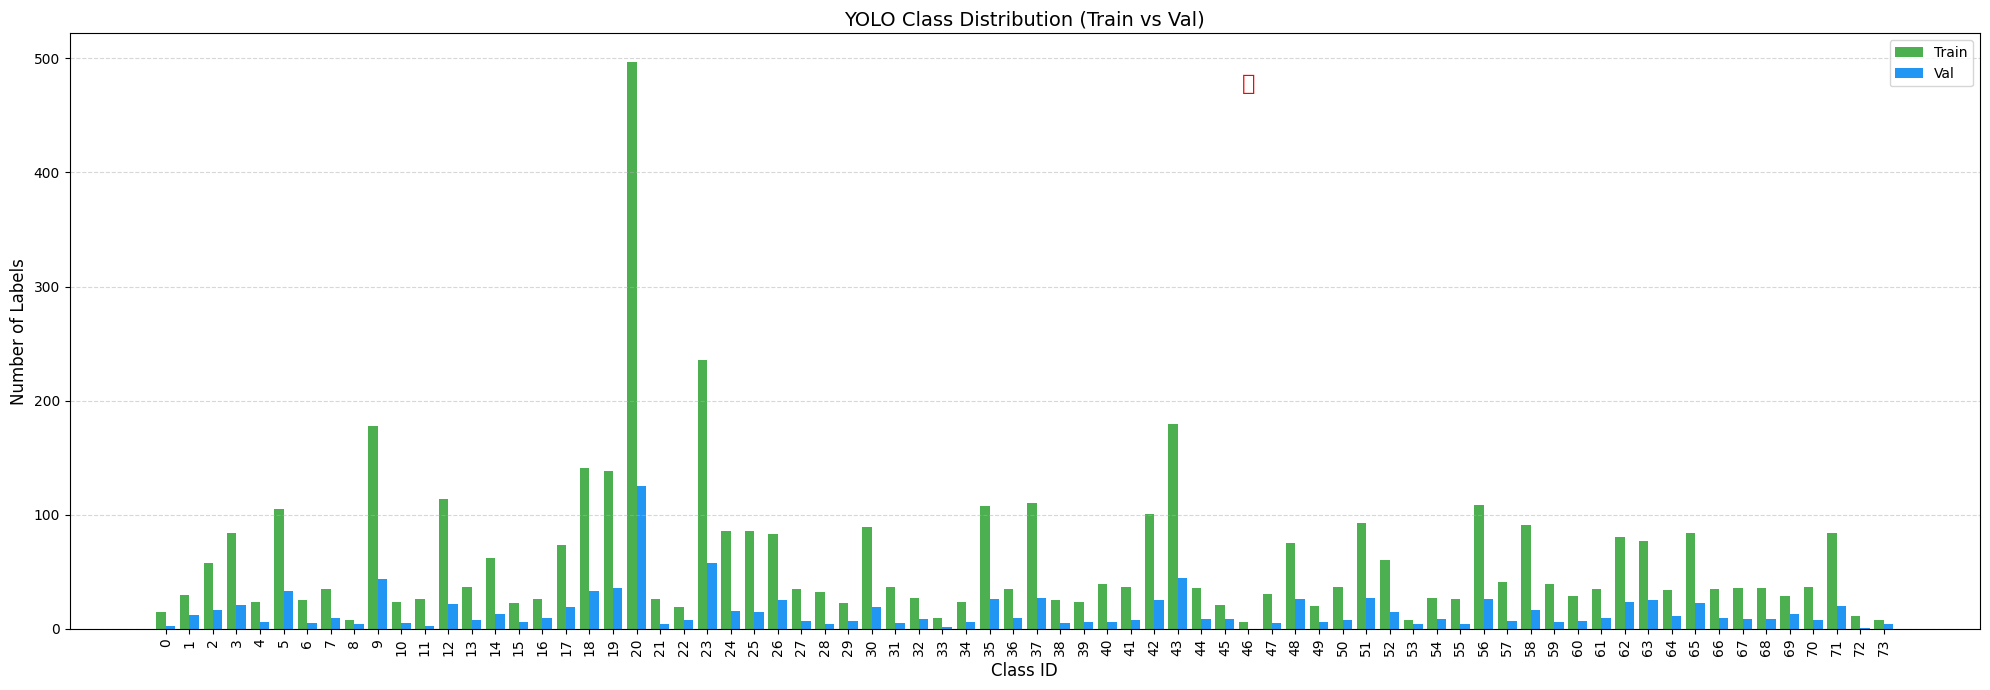

In [ ]:
# 클래스 분포 시각화
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ✅ 1️⃣ 클래스 분포 계산 함수
def get_class_counts(label_dir):
    class_counts = Counter()
    for file in os.listdir(label_dir):
        if not file.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, file), "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:
                    cls_id = int(parts[0])
                    class_counts[cls_id] += 1
    return class_counts

# ✅ 2️⃣ train/val 클래스 분포 계산
train_counts = get_class_counts(f"{DATASET_DIR}/train/labels")
val_counts   = get_class_counts(f"{DATASET_DIR}/val/labels")

all_classes = sorted(set(train_counts.keys()) | set(val_counts.keys()))

train_values = [train_counts.get(c, 0) for c in all_classes]
val_values   = [val_counts.get(c, 0) for c in all_classes]

# ✅ 3️⃣ 누락 클래스 확인
missing_classes = [c for c in all_classes if c not in val_counts]
print(f"⚠️ Val에 없는 클래스: {missing_classes}")

# ✅ 4️⃣ 시각화
plt.figure(figsize=(20, 7))
bar_width = 0.4
x = range(len(all_classes))

# Train bars
plt.bar(
    [i - bar_width/2 for i in x],
    train_values,
    width=bar_width,
    label="Train",
    color="#4CAF50"
)

# Val bars
colors = ["#2196F3" if c not in missing_classes else "#E91E63" for c in all_classes]
plt.bar(
    [i + bar_width/2 for i in x],
    val_values,
    width=bar_width,
    label="Val",
    color=colors
)

# ✅ 5️⃣ 그래프 스타일
plt.xticks(x, all_classes, rotation=90)
plt.xlabel("Class ID", fontsize=12)
plt.ylabel("Number of Labels", fontsize=12)
plt.title("YOLO Class Distribution (Train vs Val)", fontsize=14)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 누락 클래스 강조 텍스트
for mc in missing_classes:
    plt.text(mc, max(train_values) * 0.95, "❌", color="red", ha="center", fontsize=16)

plt.tight_layout()
plt.show()

📸 클래스 46 포함 이미지 4개 발견
['K-001900-010224-016551-031705_0_2_0_2_75_000_200_png.rf.94e21213d873717e61a362ca7736f0bc.jpg', 'K-001900-010224-016551-033009_0_2_0_2_75_000_200_png.rf.68c07dd78551d98fb06a19f8ef70dc23.jpg', 'K-001900-010224-016551-033009_0_2_0_2_90_000_200_png.rf.a9a75e811d8953e5cc7abb124eeea78e.jpg', 'K-001900-010224-016551-031705_0_2_0_2_70_000_200_png.rf.d65884a57f3bc07c09836fbaa5ccc1e8.jpg']


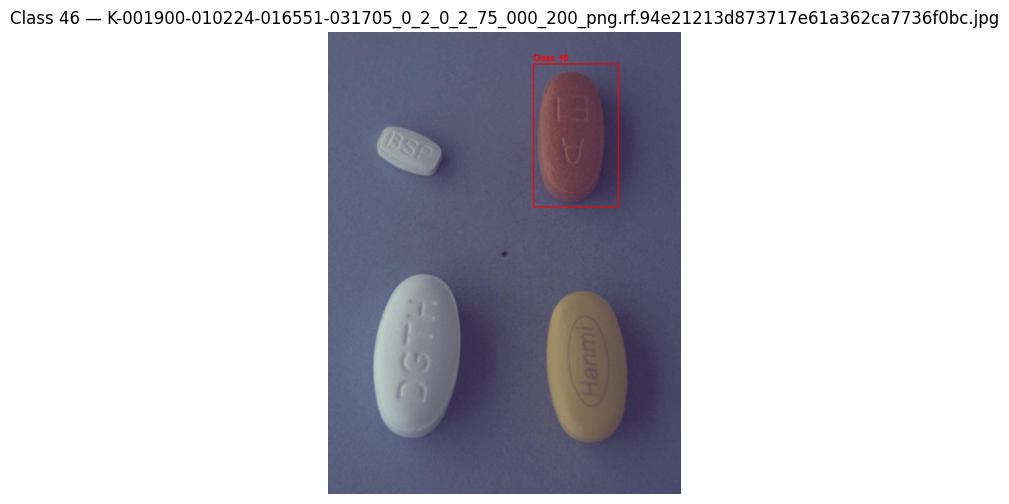

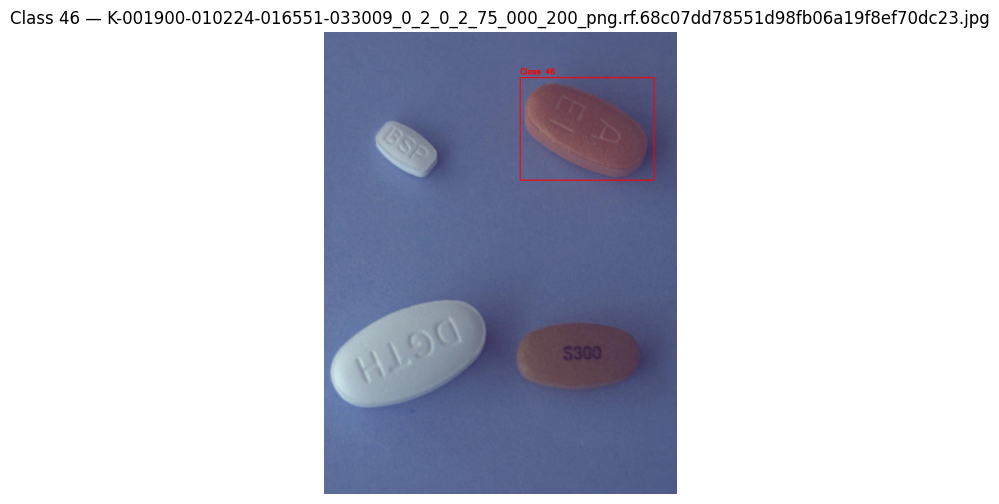

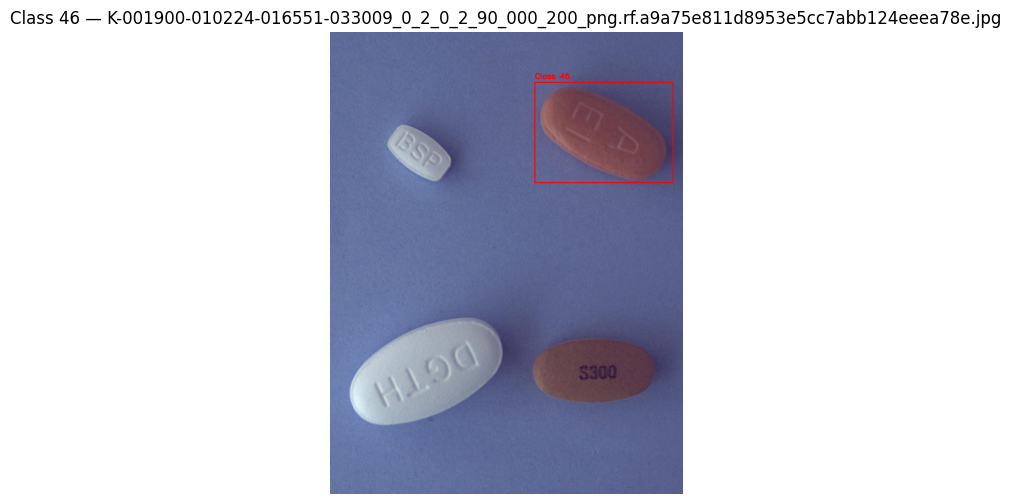

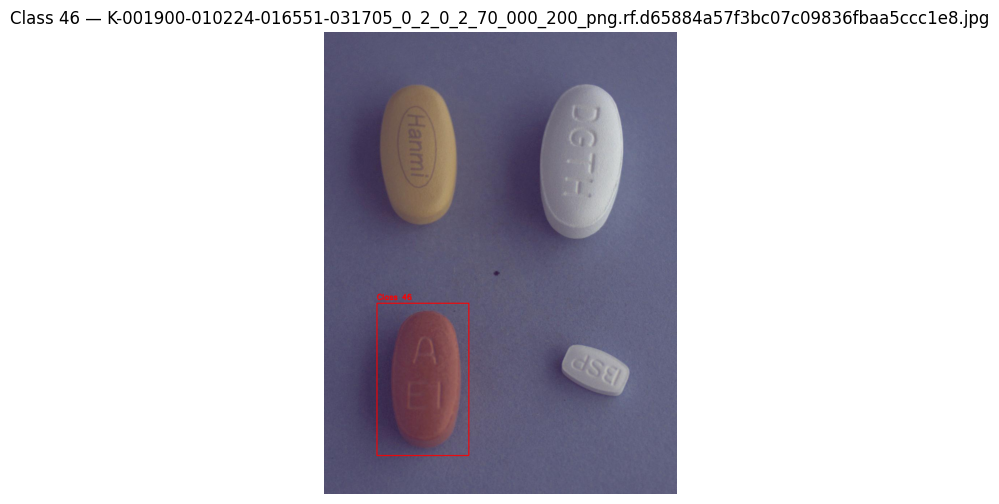

In [ ]:
# @title 클래스 46 시각화
import os
import cv2
import matplotlib.pyplot as plt

# ✅ 설정
TARGET_CLASS = 46  # 확인하고 싶은 클래스 번호
TRAIN_IMG_DIR = f"{DATASET_DIR}/train/images"
TRAIN_LBL_DIR = f"{DATASET_DIR}/train/labels"

# ✅ 1️⃣ class 46이 포함된 이미지 탐색
def find_images_with_class(label_dir, target_class, max_results=5):
    matched = []
    for lbl_file in os.listdir(label_dir):
        if not lbl_file.endswith(".txt"):
            continue
        lbl_path = os.path.join(label_dir, lbl_file)
        with open(lbl_path, "r") as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]
            for line in lines:
                cls_id = int(line.split()[0])
                if cls_id == target_class:
                    matched.append(lbl_file.replace(".txt", ".jpg"))
                    break
        if len(matched) >= max_results:
            break
    return matched

# ✅ 2️⃣ class 46 이미지 추출
matched_imgs = find_images_with_class(TRAIN_LBL_DIR, TARGET_CLASS, max_results=5)
print(f"📸 클래스 {TARGET_CLASS} 포함 이미지 {len(matched_imgs)}개 발견")
print(matched_imgs)

# ✅ 3️⃣ 시각화
for img_name in matched_imgs:
    img_path = os.path.join(TRAIN_IMG_DIR, img_name)
    lbl_path = os.path.join(TRAIN_LBL_DIR, img_name.replace(".jpg", ".txt"))

    if not os.path.exists(img_path) or not os.path.exists(lbl_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    with open(lbl_path, "r") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        for line in lines:
            cls_id, x, y, bw, bh = map(float, line.split())
            if int(cls_id) == TARGET_CLASS:
                # YOLO → 픽셀 좌표 변환
                cx, cy = int(x * w), int(y * h)
                bw, bh = int(bw * w), int(bh * h)
                x1, y1 = cx - bw // 2, cy - bh // 2
                x2, y2 = cx + bw // 2, cy + bh // 2

                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(img, f"Class {int(cls_id)}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Class {TARGET_CLASS} — {img_name}")
    plt.show()


In [ ]:
# @title 누락 클래스 train -> val 폴더로 이동

import os, shutil
'''
val에 5장 미만 클래스 보정 (train → val 이동, 클래스 총개수 고려)
클래스 총 개수 ≥15	 5장까지 이동
클래스 총 개수 10–14 3장까지 이동
클래스 총 개수 <10	 2장까지 이동
'''
# ✅ 기본 파라미터
MIN_VAL_COUNT = 5

# ✅ 3️⃣ 부족한 클래스 보정 (train → val 이동)
for cls_id in set(missing_classes + list(few_classes.keys())):
    total_count = train_counts.get(cls_id, 0) + val_counts.get(cls_id, 0)
    val_count = val_counts.get(cls_id, 0)

    # 🧠 총 개수에 따른 목표 val 개수 설정
    if total_count < 10:
        target_val_count = min(2, total_count // 2)   # 최대 2장
    elif total_count < 15:
        target_val_count = 3
    else:
        target_val_count = MIN_VAL_COUNT

    # 🧮 현재 개수보다 부족한 만큼만 이동
    need_count = max(0, target_val_count - val_count)
    if need_count == 0:
        continue

    candidates = train_map.get(cls_id, [])
    if not candidates:
        continue

    for lbl_file in candidates[:need_count]:
        img_name = lbl_file.replace(".txt", ".jpg")

        src_lbl = os.path.join(TRAIN_LBL_DIR, lbl_file)
        src_img = os.path.join(TRAIN_IMG_DIR, img_name)
        if not os.path.exists(src_img):
            src_img = src_img.replace(".jpg", ".png")

        dst_lbl = os.path.join(VAL_LBL_DIR, os.path.basename(lbl_file))
        dst_img = os.path.join(VAL_IMG_DIR, os.path.basename(src_img))

        # 파일 이동
        if os.path.exists(src_lbl) and not os.path.exists(dst_lbl):
            shutil.move(src_lbl, dst_lbl)
        if os.path.exists(src_img) and not os.path.exists(dst_img):
            shutil.move(src_img, dst_img)

        # 카운트 갱신
        val_counts[cls_id] = val_counts.get(cls_id, 0) + 1

print("\n🔁 Val 클래스 보정 완료!")

# ✅ 4️⃣ 최종 검증
train_counts_final, _ = get_class_distribution(TRAIN_LBL_DIR)
val_counts_final, _ = get_class_distribution(VAL_LBL_DIR)

print(f"\n📊 최종 Train 클래스 수: {len(train_counts_final)}")
print(f"📊 최종 Val 클래스 수:   {len(val_counts_final)}")

missing_after = sorted(list(set(train_counts_final.keys()) - set(val_counts_final.keys())))
if missing_after:
    print(f"⚠️ 여전히 Val에 없는 클래스 {len(missing_after)}개 존재 → {missing_after}")
else:
    print("✅ 모든 클래스가 Val에 적절히 분포되었습니다!")



🔁 Val 클래스 보정 완료!

📊 최종 Train 클래스 수: 74
📊 최종 Val 클래스 수:   74
✅ 모든 클래스가 Val에 적절히 분포되었습니다!


## 1.2 val -> val/test 분할

클래스 내 이미지 수	분할 기준
- 5장 미만	전부 test로 이동 (너무 적어서 학습보다는 평가에 사용)
- 5~9장	1장은 val, 나머지는 test (조금 적은 클래스는 검증 최소한만 확보)
- 10장 이상	절반 val, 절반 test	(충분한 클래스는 균등하게 분할)

In [ ]:
# @title val 폴더 → val/test 자동 분할 (클래스 기준)
import os
import shutil
from collections import defaultdict
import random

# ✅ 기본 경로 (수정 불필요)
VAL_IMG_DIR = f"{DATASET_DIR}/val/images"
VAL_LBL_DIR = f"{DATASET_DIR}/val/labels"

TEST_IMG_DIR = f"{DATASET_DIR}/test/images"
TEST_LBL_DIR = f"{DATASET_DIR}/test/labels"

os.makedirs(TEST_IMG_DIR, exist_ok=True)
os.makedirs(TEST_LBL_DIR, exist_ok=True)

# ✅ 1️⃣ 클래스별 이미지 매핑
def get_class_to_images(label_dir):
    class_to_imgs = defaultdict(list)
    img_to_classes = defaultdict(set)

    for lbl_file in os.listdir(label_dir):
        if not lbl_file.endswith(".txt"):
            continue
        lbl_path = os.path.join(label_dir, lbl_file)
        with open(lbl_path, "r") as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]
            for line in lines:
                cls_id = int(line.split()[0])
                class_to_imgs[cls_id].append(lbl_file)
                img_to_classes[lbl_file].add(cls_id)

    return class_to_imgs, img_to_classes

class_to_imgs, img_to_classes = get_class_to_images(VAL_LBL_DIR)

# ✅ 2️⃣ 이동 대상 이미지 결정
val_keep, test_move = set(), set()

for cls_id, imgs in class_to_imgs.items():
    imgs = list(set(imgs))  # 중복 제거
    count = len(imgs)

    if count < 5:
        # 5장 미만 → test 100%
        test_move.update(imgs)

    elif 5 <= count <= 9:
        # 1장만 val, 나머지 test
        random.shuffle(imgs)
        val_keep.update(imgs[:1])
        test_move.update(imgs[1:])

    else:
        # 10장 이상 → 1:1 split
        random.shuffle(imgs)
        split = count // 2
        val_keep.update(imgs[:split])
        test_move.update(imgs[split:])

# ✅ 3️⃣ 실제 이동 (이미지 + 라벨 동기화)
for lbl_file in test_move:
    img_name = lbl_file.replace(".txt", ".jpg")
    src_img = os.path.join(VAL_IMG_DIR, img_name)
    src_lbl = os.path.join(VAL_LBL_DIR, lbl_file)

    dst_img = os.path.join(TEST_IMG_DIR, img_name)
    dst_lbl = os.path.join(TEST_LBL_DIR, lbl_file)

    if os.path.exists(src_lbl):
        shutil.move(src_lbl, dst_lbl)
    if os.path.exists(src_img):
        shutil.move(src_img, dst_img)

print(f"\n📦 이동 완료: {len(test_move)}개 이미지 → test 폴더로 이동")

# ✅ 4️⃣ 검증 출력
def count_classes(label_dir):
    class_count = defaultdict(int)
    for lbl_file in os.listdir(label_dir):
        if not lbl_file.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, lbl_file)) as f:
            for line in f:
                cls_id = int(line.split()[0])
                class_count[cls_id] += 1
    return class_count

val_count = count_classes(VAL_LBL_DIR)
test_count = count_classes(TEST_LBL_DIR)

print("\n📊 최종 분포")
print(f"Val 클래스 수:  {len(val_count)}")
print(f"Test 클래스 수: {len(test_count)}")

# ⚠️ 5장 미만인 클래스 표시
few_val = {k:v for k,v in val_count.items() if v < 5}
few_test = {k:v for k,v in test_count.items() if v < 5}

if few_val:
    print("\n⚠️ Val에 5장 미만 클래스:")
    for k,v in sorted(few_val.items()):
        print(f" - Class {k}: {v}장")

if few_test:
    print("\n⚠️ Test에 5장 미만 클래스:")
    for k,v in sorted(few_test.items()):
        print(f" - Class {k}: {v}장")



📦 이동 완료: 293개 이미지 → test 폴더로 이동

📊 최종 분포
Val 클래스 수:  36
Test 클래스 수: 74

⚠️ Val에 5장 미만 클래스:
 - Class 0: 1장
 - Class 1: 1장
 - Class 3: 1장
 - Class 5: 4장
 - Class 7: 1장
 - Class 9: 4장
 - Class 10: 1장
 - Class 12: 1장
 - Class 14: 1장
 - Class 15: 1장
 - Class 16: 2장
 - Class 17: 1장
 - Class 18: 1장
 - Class 19: 4장
 - Class 21: 1장
 - Class 23: 3장
 - Class 24: 2장
 - Class 26: 1장
 - Class 28: 1장
 - Class 30: 1장
 - Class 35: 2장
 - Class 37: 1장
 - Class 42: 1장
 - Class 43: 1장
 - Class 44: 1장
 - Class 48: 3장
 - Class 51: 1장
 - Class 56: 1장
 - Class 58: 1장
 - Class 60: 1장
 - Class 61: 1장
 - Class 62: 1장
 - Class 63: 2장
 - Class 69: 3장
 - Class 71: 1장

⚠️ Test에 5장 미만 클래스:
 - Class 0: 4장
 - Class 8: 4장
 - Class 10: 4장
 - Class 21: 4장
 - Class 28: 4장
 - Class 33: 3장
 - Class 46: 2장
 - Class 53: 4장
 - Class 72: 3장
 - Class 73: 4장


## 1.3 50개 미만 희귀 클래스 데이터셋 생성

In [ ]:
# @title 50개 미만 희귀 클래스 복사 (train → rare_train, val → rare_val)
import os, shutil
from collections import defaultdict

# ✅ 기준
RARE_THRESHOLD = 50

# ✅ 경로 설정
RARE_TRAIN_IMG_DIR = f"{DATASET_DIR}/rare_train/images"
RARE_TRAIN_LBL_DIR = f"{DATASET_DIR}/rare_train/labels"
RARE_VAL_IMG_DIR   = f"{DATASET_DIR}/rare_val/images"
RARE_VAL_LBL_DIR   = f"{DATASET_DIR}/rare_val/labels"

# 폴더 생성
for d in [RARE_TRAIN_IMG_DIR, RARE_TRAIN_LBL_DIR, RARE_VAL_IMG_DIR, RARE_VAL_LBL_DIR]:
    os.makedirs(d, exist_ok=True)

# ✅ 1️⃣ 기존 class 분포 다시 계산
def get_class_distribution(label_dir):
    class_count = defaultdict(int)
    img_classes = defaultdict(list)
    for lbl_file in os.listdir(label_dir):
        if not lbl_file.endswith(".txt"):
            continue
        path = os.path.join(label_dir, lbl_file)
        with open(path, "r") as f:
            for line in f:
                if line.strip():
                    cls_id = int(line.split()[0])
                    class_count[cls_id] += 1
                    img_classes[cls_id].append(lbl_file)
    return class_count, img_classes

train_counts, train_map = get_class_distribution(TRAIN_LBL_DIR)
val_counts, val_map     = get_class_distribution(VAL_LBL_DIR)

# ✅ 2️⃣ 50개 미만 클래스 식별
rare_train_classes = [cls for cls, cnt in train_counts.items() if cnt < RARE_THRESHOLD]
rare_val_classes   = [cls for cls, cnt in val_counts.items() if cnt < RARE_THRESHOLD]

print(f"📉 희귀 클래스 기준: {RARE_THRESHOLD}장 미만")
print(f"🧩 Train 희귀 클래스 {len(rare_train_classes)}개: {rare_train_classes}")
print(f"🧩 Val 희귀 클래스   {len(rare_val_classes)}개: {rare_val_classes}")

# ✅ 3️⃣ 희귀 클래스 이미지/라벨 복사 함수
def copy_rare_classes(src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir, target_classes, cls_map):
    copied = 0
    for cls_id in target_classes:
        for lbl_file in cls_map.get(cls_id, []):
            src_lbl = os.path.join(src_lbl_dir, lbl_file)
            src_img = os.path.join(src_img_dir, lbl_file.replace(".txt", ".jpg"))
            if not os.path.exists(src_img):
                src_img = src_img.replace(".jpg", ".png")

            dst_lbl = os.path.join(dst_lbl_dir, os.path.basename(lbl_file))
            dst_img = os.path.join(dst_img_dir, os.path.basename(src_img))

            if os.path.exists(src_lbl) and not os.path.exists(dst_lbl):
                shutil.copy(src_lbl, dst_lbl)
            if os.path.exists(src_img) and not os.path.exists(dst_img):
                shutil.copy(src_img, dst_img)
            copied += 1
    return copied

# ✅ 4️⃣ 복사 실행
train_copied = copy_rare_classes(TRAIN_IMG_DIR, TRAIN_LBL_DIR, RARE_TRAIN_IMG_DIR, RARE_TRAIN_LBL_DIR, rare_train_classes, train_map)
val_copied   = copy_rare_classes(VAL_IMG_DIR, VAL_LBL_DIR, RARE_VAL_IMG_DIR, RARE_VAL_LBL_DIR, rare_val_classes, val_map)

print(f"\n✅ 복사 완료!")
print(f"📦 rare_train: {train_copied}개 파일 복사됨")
print(f"📦 rare_val:   {val_copied}개 파일 복사됨")


📉 희귀 클래스 기준: 50장 미만
🧩 Train 희귀 클래스 46개: [60, 31, 57, 44, 16, 13, 67, 68, 36, 15, 7, 40, 29, 66, 41, 70, 38, 54, 59, 64, 6, 47, 34, 39, 45, 11, 32, 50, 28, 61, 8, 27, 10, 4, 22, 55, 72, 1, 49, 69, 33, 21, 53, 73, 0, 46]
🧩 Val 희귀 클래스   72개: [42, 27, 19, 72, 55, 29, 11, 0, 1, 51, 21, 37, 9, 28, 50, 18, 33, 46, 59, 44, 3, 63, 35, 38, 8, 12, 48, 71, 65, 30, 25, 17, 26, 54, 68, 10, 6, 5, 58, 4, 22, 43, 40, 41, 52, 69, 2, 70, 66, 56, 7, 36, 62, 61, 14, 34, 45, 24, 16, 53, 60, 32, 49, 13, 73, 31, 57, 47, 67, 15, 39, 64]

✅ 복사 완료!
📦 rare_train: 1226개 파일 복사됨
📦 rare_val:   987개 파일 복사됨


In [ ]:
# @title 희귀클래스 train/val 병합
# 초기에 train val로 나눠 학습하려 했으나 증강 및 k-fold학습 목적으로 original 폴더 하나로 병합했음

# ----------------------------------------------------------
# rare_train + rare_val → rare/original 통합
# ----------------------------------------------------------
import os, shutil

# ✅ 기존 희귀 폴더 경로
RARE_TRAIN_IMG_DIR = f"{DATASET_DIR}/rare_train/images"
RARE_TRAIN_LBL_DIR = f"{DATASET_DIR}/rare_train/labels"
RARE_VAL_IMG_DIR   = f"{DATASET_DIR}/rare_val/images"
RARE_VAL_LBL_DIR   = f"{DATASET_DIR}/rare_val/labels"

# ✅ 통합 대상 (train + val)
SOURCE_DIRS = [
    (RARE_TRAIN_IMG_DIR, RARE_TRAIN_LBL_DIR),
    (RARE_VAL_IMG_DIR,   RARE_VAL_LBL_DIR)
]

# ✅ 통합 목적지 (rare/original)
RARE_ORIG_IMG_DIR = f"{BASE_DIR}/datasets_balanced/rare/original/images"
RARE_ORIG_LBL_DIR = f"{BASE_DIR}/datasets_balanced/rare/original/labels"

os.makedirs(RARE_ORIG_IMG_DIR, exist_ok=True)
os.makedirs(RARE_ORIG_LBL_DIR, exist_ok=True)

# ✅ 복사 함수 정의
def merge_rare_sources(src_dirs, dst_img_dir, dst_lbl_dir):
    copied_imgs, copied_lbls = 0, 0
    seen_files = set()  # 중복 방지

    for src_img_dir, src_lbl_dir in src_dirs:
        for lbl_file in os.listdir(src_lbl_dir):
            if not lbl_file.endswith(".txt"):
                continue

            img_file = lbl_file.replace(".txt", ".jpg")
            src_img = os.path.join(src_img_dir, img_file)
            src_lbl = os.path.join(src_lbl_dir, lbl_file)

            # 중복 방지
            if lbl_file in seen_files:
                continue
            seen_files.add(lbl_file)

            dst_img = os.path.join(dst_img_dir, img_file)
            dst_lbl = os.path.join(dst_lbl_dir, lbl_file)

            # ✅ 라벨 복사
            if os.path.exists(src_lbl) and not os.path.exists(dst_lbl):
                shutil.copy(src_lbl, dst_lbl)
                copied_lbls += 1

            # ✅ 이미지 복사
            if os.path.exists(src_img) and not os.path.exists(dst_img):
                shutil.copy(src_img, dst_img)
                copied_imgs += 1

    return copied_imgs, copied_lbls

# ✅ 실행
copied_imgs, copied_lbls = merge_rare_sources(SOURCE_DIRS, RARE_ORIG_IMG_DIR, RARE_ORIG_LBL_DIR)

print(f"✅ 통합 완료!")
print(f"📸 이미지 복사: {copied_imgs}개")
print(f"📝 라벨 복사: {copied_lbls}개")
print(f"📂 최종 경로: {RARE_ORIG_IMG_DIR}")

## 1.4 SSD, FRCNN 학습을 위한 JSON 생성

In [ ]:
# @title 로보플로우에서 받은 json 파일 하나로 병합

import os, json
from collections import defaultdict

# ----------------------------------------------------------
# ✅ 경로 설정
# ----------------------------------------------------------
ROOT_DIR = "/content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced"

TRAIN_JSON = os.path.join(ROOT_DIR, "base/train/train_annotations_original.json")
VAL_JSON   = os.path.join(ROOT_DIR, "base/val/val_annotations_original.json")
OUTPUT_JSON = os.path.join(ROOT_DIR, "annotations_original_all.json")

# ----------------------------------------------------------
# ✅ 유효성 검사
# ----------------------------------------------------------
for p in [TRAIN_JSON, VAL_JSON]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"❌ {p} 파일이 존재하지 않습니다.")

# ----------------------------------------------------------
# ✅ JSON 병합 함수
# ----------------------------------------------------------
def merge_original_jsons(train_path, val_path, save_path):
    print("📦 원본 JSON 병합 시작")

    file_to_annos = defaultdict(list)
    file_to_imgmeta = {}
    categories = []

    # ✅ train + val 순서대로 병합
    for path in [train_path, val_path]:
        print(f"📂 처리 중: {path}")
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        imgs = data.get("images", [])
        anns = data.get("annotations", [])
        cats = data.get("categories", [])

        # categories는 첫 파일 기준으로만 채택
        if not categories:
            categories = cats

        # 이미지 id → 파일명 매핑
        id2name = {img["id"]: os.path.basename(img["file_name"]) for img in imgs}

        # 이미지 메타 저장 (width, height 포함)
        for img in imgs:
            fname = os.path.basename(img["file_name"])
            file_to_imgmeta[fname] = img

        # 어노테이션 병합
        for ann in anns:
            fname = id2name.get(ann["image_id"])
            if fname:
                file_to_annos[fname].append(ann)

    # ----------------------------------------------------------
    # ✅ 통합 결과 저장
    # ----------------------------------------------------------
    merged_data = {
        "annotations_by_file": file_to_annos,
        "images_meta": file_to_imgmeta,
        "categories": categories
    }

    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(merged_data, f, ensure_ascii=False, indent=2)

    print(f"\n✅ 통합 완료 → {save_path}")
    print(f"📊 총 이미지 수: {len(file_to_annos)}")
    print(f"📊 총 어노테이션이 있는 이미지: {sum(1 for v in file_to_annos.values() if v)}")
    print(f"📁 카테고리 수: {len(categories)}")


# ----------------------------------------------------------
# ✅ 실행
# ----------------------------------------------------------
merge_original_jsons(TRAIN_JSON, VAL_JSON, OUTPUT_JSON)

📦 원본 JSON 병합 시작
📂 처리 중: /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/base/train/train_annotations_original.json
📂 처리 중: /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/base/val/val_annotations_original.json

✅ 통합 완료 → /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/annotations_original_all.json
📊 총 이미지 수: 1489
📊 총 어노테이션이 있는 이미지: 1489
📁 카테고리 수: 75


In [ ]:
# @title JSON 생성코드

import os, json, shutil
from collections import defaultdict

# ----------------------------------------------------------
# ✅ 경로 설정
# ----------------------------------------------------------
ROOT_DIR = "/content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced"

# 전역 통합 원본 (이미 만들어진 annotations_original_all.json)
MERGED_ORIGINAL_PATH = os.path.join(ROOT_DIR, "annotations_original_all.json")

# 재생성 대상 세트
TARGET_SETS = {
    "train": os.path.join(ROOT_DIR, "base/train"),
    "val": os.path.join(ROOT_DIR, "base/val"),
    "test": os.path.join(ROOT_DIR, "base/test"),
    "original": os.path.join(ROOT_DIR, "rare/original"),
}

# ----------------------------------------------------------
# ✅ 통합 원본 로드
# ----------------------------------------------------------
if not os.path.exists(MERGED_ORIGINAL_PATH):
    raise FileNotFoundError(f"❌ 통합 원본 파일이 없습니다: {MERGED_ORIGINAL_PATH}")

print(f"📦 병합 원본 파일 로드 중: {MERGED_ORIGINAL_PATH}")
with open(MERGED_ORIGINAL_PATH, "r", encoding="utf-8") as f:
    master_data = json.load(f)

master_anno = master_data.get("annotations_by_file", {})
print(f"✅ 총 {len(master_anno)}개 이미지의 어노테이션 로드 완료")

# ----------------------------------------------------------
# ✅ COCO JSON 재생성 함수
# ----------------------------------------------------------
def recreate_json(set_name, set_path):
    print(f"\n==============================")
    print(f"🧩 세트: {set_name}")
    print("==============================")

    img_dir = os.path.join(set_path, "images")
    json_path = os.path.join(set_path, "annotations.json")

    if not os.path.exists(img_dir):
        print(f"⚠️ {set_name}: 이미지 폴더 없음 → 건너뜀")
        return

    # 백업
    if os.path.exists(json_path):
        backup_path = json_path.replace(".json", "_backup.json")
        shutil.copy(json_path, backup_path)
        print(f"💾 기존 파일 백업 완료 → {backup_path}")

    # 폴더 내 실제 이미지 수집
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    print(f"📷 감지된 이미지 수: {len(img_files)}")

    images, annotations = [], []
    next_image_id = 1
    next_annotation_id = 1

    for fname in sorted(img_files):
        img_id = next_image_id
        images.append({
            "id": img_id,
            "file_name": fname
        })
        next_image_id += 1

        # 원본 어노테이션 매칭
        basename = os.path.basename(fname)
        if basename in master_anno:
            for ann in master_anno[basename]:
                ann_copy = ann.copy()
                ann_copy["image_id"] = img_id
                ann_copy["id"] = next_annotation_id
                annotations.append(ann_copy)
                next_annotation_id += 1

    # categories는 master_anno에 포함되지 않으므로 기존 JSON에서 복사
    # 우선 train set에서 가져옴
    base_train_json = os.path.join(ROOT_DIR, "base/train/train_annotations_original.json")
    if os.path.exists(base_train_json):
        with open(base_train_json, "r", encoding="utf-8") as f:
            base_train_data = json.load(f)
        categories = base_train_data.get("categories", [])
    else:
        print("⚠️ categories 정보를 찾을 수 없어 빈 리스트로 생성합니다.")
        categories = []

    new_json = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(new_json, f, ensure_ascii=False, indent=2)

    print(f"✅ {set_name}/annotations.json 생성 완료")
    print(f"📊 이미지 {len(images)}장 / 어노테이션 {len(annotations)}개")

# ----------------------------------------------------------
# ✅ 전체 세트 재생성 실행
# ----------------------------------------------------------
for name, path in TARGET_SETS.items():
    recreate_json(name, path)

📦 병합 원본 파일 로드 중: /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/annotations_original_all.json
✅ 총 1489개 이미지의 어노테이션 로드 완료

🧩 세트: train
💾 기존 파일 백업 완료 → /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/base/train/annotations_backup.json
📷 감지된 이미지 수: 1180
✅ train/annotations.json 생성 완료
📊 이미지 1180장 / 어노테이션 4488개

🧩 세트: val
💾 기존 파일 백업 완료 → /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/base/val/annotations_backup.json
📷 감지된 이미지 수: 16
✅ val/annotations.json 생성 완료
📊 이미지 16장 / 어노테이션 61개

🧩 세트: test
💾 기존 파일 백업 완료 → /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/base/test/annotations_backup.json
📷 감지된 이미지 수: 293
✅ test/annotations.json 생성 완료
📊 이미지 293장 / 어노테이션 1113개

🧩 세트: original
💾 기존 파일 백업 완료 → /content/drive/MyDrive/AI 엔지니어 과정 2025/git/Codeit_Pill_Detection_Project_new/datasets_balanced/rare/original/annot

In [ ]:
# @title 검증코드

# ----------------------------------------------------------
# ✅ 검증 함수
# ----------------------------------------------------------
def verify_dataset(set_name, set_path):
    print(f"\n==============================")
    print(f"🔍 세트: {set_name}")
    print("==============================")

    json_path = os.path.join(set_path, "annotations.json")
    img_dir = os.path.join(set_path, "images")

    if not os.path.exists(json_path):
        print(f"⚠️ {set_name}: annotations.json 없음 → 건너뜀")
        return
    if not os.path.exists(img_dir):
        print(f"⚠️ {set_name}: images 폴더 없음 → 건너뜀")
        return

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    imgs = data.get("images", [])
    anns = data.get("annotations", [])
    cats = data.get("categories", [])

    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    img_names_json = {os.path.basename(i["file_name"]) for i in imgs}
    img_names_folder = set(img_files)

    # 1️⃣ 이미지 매칭 확인
    missing_in_folder = img_names_json - img_names_folder
    missing_in_json = img_names_folder - img_names_json
    print(f"📷 JSON 내 이미지: {len(imgs)} / 폴더 내 실제 이미지: {len(img_files)}")
    print(f"🤝 매칭된 이미지: {len(img_names_json & img_names_folder)}")

    if missing_in_folder:
        print(f"❌ 폴더에 없는 이미지 {len(missing_in_folder)}개 예시:")
        print("   ", list(missing_in_folder)[:5])
    if missing_in_json:
        print(f"❌ JSON에 없는 이미지 {len(missing_in_json)}개 예시:")
        print("   ", list(missing_in_json)[:5])

    # 2️⃣ 어노테이션 연결 확인
    img_ids_json = {i["id"] for i in imgs}
    ann_ids = {a["id"] for a in anns}
    gt_image_ids = {a["image_id"] for a in anns}
    missing_gt = [i["file_name"] for i in imgs if i["id"] not in gt_image_ids]
    print(f"📊 어노테이션 총 {len(anns)}개 / 연결된 이미지 {len(gt_image_ids)}개")

    if missing_gt:
        print(f"⚠️ 어노테이션 없는 이미지 {len(missing_gt)}개 예시:")
        print("   ", missing_gt[:5])
    else:
        print("🎯 모든 이미지에 어노테이션이 연결되어 있음")

    # 3️⃣ 중복 ID 및 참조 오류 확인
    if len(img_ids_json) != len(imgs):
        print("⚠️ 이미지 ID 중복 있음")
    if len(ann_ids) != len(anns):
        print("⚠️ 어노테이션 ID 중복 있음")

    invalid_refs = [a for a in anns if a["image_id"] not in img_ids_json]
    if invalid_refs:
        print(f"⚠️ 유효하지 않은 image_id 참조 {len(invalid_refs)}개 존재")
    else:
        print("✅ image_id 참조 무결성 확인 완료")

    print(f"📁 categories 수: {len(cats)}")
    print("✅ 검증 완료")


# ----------------------------------------------------------
# ✅ 전체 세트 검증 실행
# ----------------------------------------------------------
for name, path in TARGET_SETS.items():
    verify_dataset(name, path)


🔍 세트: train
📷 JSON 내 이미지: 1180 / 폴더 내 실제 이미지: 1180
🤝 매칭된 이미지: 1180
📊 어노테이션 총 4488개 / 연결된 이미지 1180개
🎯 모든 이미지에 어노테이션이 연결되어 있음
✅ image_id 참조 무결성 확인 완료
📁 categories 수: 75
✅ 검증 완료

🔍 세트: val
📷 JSON 내 이미지: 16 / 폴더 내 실제 이미지: 16
🤝 매칭된 이미지: 16
📊 어노테이션 총 61개 / 연결된 이미지 16개
🎯 모든 이미지에 어노테이션이 연결되어 있음
✅ image_id 참조 무결성 확인 완료
📁 categories 수: 75
✅ 검증 완료

🔍 세트: test
📷 JSON 내 이미지: 293 / 폴더 내 실제 이미지: 293
🤝 매칭된 이미지: 293
📊 어노테이션 총 1113개 / 연결된 이미지 293개
🎯 모든 이미지에 어노테이션이 연결되어 있음
✅ image_id 참조 무결성 확인 완료
📁 categories 수: 75
✅ 검증 완료

🔍 세트: original
📷 JSON 내 이미지: 992 / 폴더 내 실제 이미지: 992
🤝 매칭된 이미지: 992
📊 어노테이션 총 3674개 / 연결된 이미지 992개
🎯 모든 이미지에 어노테이션이 연결되어 있음
✅ image_id 참조 무결성 확인 완료
📁 categories 수: 75
✅ 검증 완료
